<a href="https://colab.research.google.com/github/mucollabo/firstGAN/blob/main/07_training_handwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Handwritten Digits - MNIST GAN With Seed Experiments
===
#### Make Your First GAN With PyTorch, 20202


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

Dataset class
===

In [3]:
class MnistDataset(Dataset):

  def __init__(self, csv_file):
    self.data_df = pd.read_csv(csv_file, header=None)
    pass

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    # 이미지 목표(레이블)
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    # 0~255의 이미지를 0~1로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values)

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass

  pass


In [4]:
# load data
mnist_dataset = MnistDataset("/content/drive/MyDrive/ColabNotebooks/myo_gan/mnist_data/mnist_train.csv")

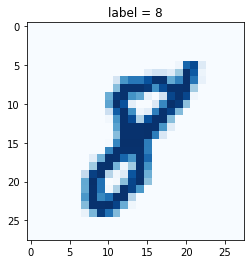

In [5]:
# check data contain images
mnist_dataset.plot_image(17)

Data Functions
===

In [6]:
# functions to generate random data

def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

Discriminator Network
===

In [7]:
from pandas.core.frame import DataFrame
# discriminator class

class Discriminator(nn.Module):

  def __init__(self):
    # initialise parent pytorch class
    super().__init__()

    # define neural network layers
    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.Sigmoid(),
        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    # create loss function
    self.loss_function = nn.BCELoss()

    # create optimiser, simple stochastic gradient descent
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.001)

    # counter and accumulator for progress
    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    # simply run model
    return self.model(inputs)

  def train(self, inputs, targets):
    # calculate the output of the network
    outputs = self.forward(inputs)

    # calculate loss
    loss = self.loss_function(outputs, targets)

    # increase counter and accumulate error every 10
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    # zero gradients, perform a backward pass, update weights
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass

  pass

Test Discriminator
===

In [8]:
%%time
# test dicriminator can seperate real data from random noise

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  # real data
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  # fake data
  D.train(generate_random_image(784), torch.FloatTensor([0.0]))
  pass


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 6min, sys: 4.37 s, total: 6min 4s
Wall time: 6min 4s


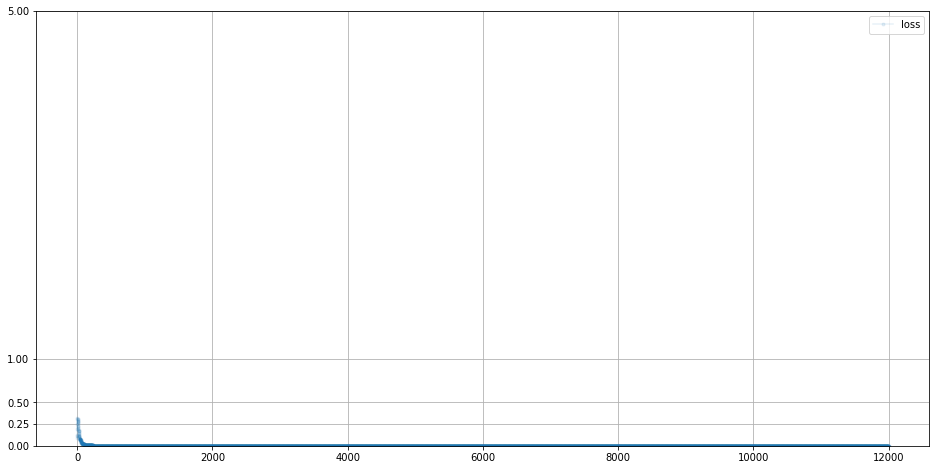

In [9]:
D.plot_progress()

In [10]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random_image(784)).item())
  pass

1.0
1.0
1.0
1.0
1.7544524860690913e-11
1.776352676063908e-11
1.7503746715941126e-11
1.7660286427689798e-11
